# 1. Introduction

### 1.1 Background


Video games aren’t just for entertainment, they also provide valuable information about human behavior! Dr. Frank Wood and his research group in Computer Science at UBC has collected data about player information through a minecraft server, including characteristics such as age, gender, total game play. Managing and maintaining the server won’t be an easy task, so they are seeking answers to some questions such as what kinds of players join, and who is likely to engage more deeply with the project. In particular, we will be focusing on answering the question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?


### 1.2 Basic Dataset Description
* Response variable: **subscribe** is chosen since its a TRUE/FALSE, categorical variable, it is available for prediction using classification algorithms
* Explanatory variables:
    * **experience** (factor: Pro, Veteran, etc.)
    * **played_hours** (numeric)
    * **Age** (numeric)
    * **gender** (categorical)
* How data will help answer question:
    * players.csv directly provides all predictors.
    * No merging is needed, unless more specific description is wanted e.g., number of sessions
    * subscribe is cleanly provided as a catagorical variable with only 2 classes
* Wrangling needed:
    * Convert categorical variables (experience, gender) to factors
    * Remove missing values (NA) in all predictors
    * Possibly normalize played_hours
    * Result in a tidy tibble by removing redundent or duplicate columns (hashedEmail) or selecting only columns of intrest
* Predictive method:
    * Works with k-NN classification

### 1.2.1 File Reading and Preview


In [1]:
#Needed Libraries:
library(tidyverse) 
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Read the data
players  <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Preview datasets
head(players)
head(sessions)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### 1.2.2 Overview: Number of Observations and Variables

In [4]:
dataset_overview <- tibble(
  dataset        = c("players", "sessions"),
  n_observations = c(nrow(players), nrow(sessions)),
  n_variables    = c(ncol(players), ncol(sessions))
)

dataset_overview

dataset,n_observations,n_variables
<chr>,<int>,<int>
players,196,7
sessions,1535,5


### 1.2.3 Variable Summaries (players.csv, sessions.csv)

In [5]:
players_var_summary <- tibble(
  variable = c("experience", "subscribe", "hashedEmail",
               "played_hours", "name", "gender", "Age"),
  
  type = c("categorical", "categorical", "character",
           "numeric", "character", "categorical", "numeric"),
  
  description = c(
    "Self reported experience level",
    "YES or NO for subscribed to the game-related newsletter",
    "Hashed email identifier used to link to sessions.csv",
    "Total hours the player has spent on the server",
    "Player's in-game name (may not be unique)",
    "Player gender",
    "Player age in years"
  )
)

players_var_summary

sessions_var_summary <- tibble(
  variable = c("hashedEmail", "start_time", "end_time",
               "original_start_time", "original_end_time"),
  
  type = c("character", "character", "character",
           "numeric", "numeric"),
  
  description = c(
    "Hashed email identifier used to link to players.csv",
    "Session start time as readable string (dd/mm/yyyy HH:MM)",
    "Session end time as readable string",
    "Session start time as system clock value",
    "Session end time as system clock value"
  )
)

sessions_var_summary


variable,type,description
<chr>,<chr>,<chr>
experience,categorical,Self reported experience level
subscribe,categorical,YES or NO for subscribed to the game-related newsletter
hashedEmail,character,Hashed email identifier used to link to sessions.csv
played_hours,numeric,Total hours the player has spent on the server
name,character,Player's in-game name (may not be unique)
gender,categorical,Player gender
Age,numeric,Player age in years


variable,type,description
<chr>,<chr>,<chr>
hashedEmail,character,Hashed email identifier used to link to players.csv
start_time,character,Session start time as readable string (dd/mm/yyyy HH:MM)
end_time,character,Session end time as readable string
original_start_time,numeric,Session start time as system clock value
original_end_time,numeric,Session end time as system clock value


### 1.2.4 Numeric Summary Statistics (2 decimals)

In [6]:
players_numeric_summary <- players |>
  summarise(
    played_hours_mean = round(mean(played_hours, na.rm = TRUE), 2),
    played_hours_sd   = round(sd(played_hours, na.rm = TRUE), 2),
    played_hours_min  = round(min(played_hours, na.rm = TRUE), 2),
    played_hours_max  = round(max(played_hours, na.rm = TRUE), 2),
    Age_mean          = round(mean(Age, na.rm = TRUE), 2),
    Age_sd            = round(sd(Age, na.rm = TRUE), 2),
    Age_min           = round(min(Age, na.rm = TRUE), 2),
    Age_max           = round(max(Age, na.rm = TRUE), 2)
  )

players_numeric_summary

sessions_numeric_summary <- sessions |>
  summarise(
    original_start_time_mean = round(mean(original_start_time, na.rm = TRUE), 2),
    original_start_time_sd   = round(sd(original_start_time, na.rm = TRUE), 2),
    original_start_time_min  = round(min(original_start_time, na.rm = TRUE), 2),
    original_start_time_max  = round(max(original_start_time, na.rm = TRUE), 2),
    original_end_time_mean   = round(mean(original_end_time, na.rm = TRUE), 2),
    original_end_time_sd     = round(sd(original_end_time, na.rm = TRUE), 2),
    original_end_time_min    = round(min(original_end_time, na.rm = TRUE), 2),
    original_end_time_max    = round(max(original_end_time, na.rm = TRUE), 2)
  )

sessions_numeric_summary

played_hours_mean,played_hours_sd,played_hours_min,played_hours_max,Age_mean,Age_sd,Age_min,Age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.85,28.36,0,223.1,21.14,7.39,9,58


original_start_time_mean,original_start_time_sd,original_start_time_min,original_start_time_max,original_end_time_mean,original_end_time_sd,original_end_time_min,original_end_time_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.719201e+12,3557491589,1.7124e+12,1.72733e+12,1.719196e+12,3552813134,1.7124e+12,1.72734e+12


### 1.2.5 Categorical summaries

In [7]:
# players: experience
players_experience_counts <- players |>
  count(experience)

players_experience_counts

# players: subscribe
players_subscribe_counts <- players |>
  count(subscribe)

players_subscribe_counts

# players: gender
players_gender_counts <- players |>
  count(gender)

players_gender_counts

experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,144


gender,n
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


### 1.2.6 Missing values

In [8]:
players_missing <- tibble(
  variable   = c("experience", "subscribe", "hashedEmail",
                 "played_hours", "name", "gender", "Age"),
  n_missing  = c(
    sum(is.na(players$experience)),
    sum(is.na(players$subscribe)),
    sum(is.na(players$hashedEmail)),
    sum(is.na(players$played_hours)),
    sum(is.na(players$name)),
    sum(is.na(players$gender)),
    sum(is.na(players$Age))
  )
)

players_missing

sessions_missing <- tibble(
  variable  = c("hashedEmail", "start_time", "end_time",
                "original_start_time", "original_end_time"),
  n_missing = c(
    sum(is.na(sessions$hashedEmail)),
    sum(is.na(sessions$start_time)),
    sum(is.na(sessions$end_time)),
    sum(is.na(sessions$original_start_time)),
    sum(is.na(sessions$original_end_time))
  )
)

sessions_missing

variable,n_missing
<chr>,<int>
experience,0
subscribe,0
hashedEmail,0
played_hours,0
name,0
gender,0
Age,2


variable,n_missing
<chr>,<int>
hashedEmail,0
start_time,0
end_time,2
original_start_time,0
original_end_time,2


### 1.2.7 Data Quality

#### Uniqueness of hashedEmail in players

In [9]:
players_hashedEmail_uniqueness <- players |>
  summarise(
    n_players          = n(),
    n_unique_hashed_id = length(unique(hashedEmail))
  )

players_hashedEmail_uniqueness

n_players,n_unique_hashed_id
<int>,<int>
196,196


#### Number of players have at least one session

In [10]:
players_with_sessions <- sessions |>
  select(hashedEmail) |>
  distinct() |>
  inner_join(players, by = "hashedEmail") |>
  summarise(n_players_with_sessions = n())

players_with_sessions

n_players_with_sessions
<int>
125


# 1.3 Detailed Dataset Description and Visual

In [11]:
# Make Data Tidy 
players_tidy <- players |>
  mutate(
    subscribe = as_factor(subscribe),
    experience = as_factor(experience),
    gender = as_factor(gender),
    hashedEmail = as.character(hashedEmail)) |> 
    select(subscribe, experience, played_hours, Age, gender) |> drop_na() #variables of intrest are retained and rows with NA observations dropped
slice(players_tidy, 1:8) #for preview

sessions_tidy <- sessions |>
  mutate(
    start_time = as_datetime(start_time, format = "%d/%m/%Y %H:%M"),
    end_time   = as_datetime(end_time,   format = "%d/%m/%Y %H:%M"),
    hashedEmail = as.character(hashedEmail)
  )
slice(sessions_tidy, 1:8)

subscribe,experience,played_hours,Age,gender
<fct>,<fct>,<dbl>,<dbl>,<fct>
TRUE,Pro,30.3,9,Male
TRUE,Veteran,3.8,17,Male
FALSE,Veteran,0.0,17,Male
TRUE,Amateur,0.7,21,Female
TRUE,Regular,0.1,21,Male
TRUE,Amateur,0.0,17,Female
TRUE,Regular,0.0,19,Female
FALSE,Amateur,0.0,21,Male


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-04-15 07:12:00,2024-04-15 07:21:00,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,2024-09-21 02:13:00,2024-09-21 02:30:00,1.72688e+12,1.72689e+12


### 1.3.1 Mean value for each quantitative variable in players.csv 

In [12]:
players_means <- players_tidy |>
  summarise(
    mean_played_hours = mean(played_hours, na.rm = TRUE),
    mean_age = mean(Age, na.rm = TRUE)
  )

players_means

mean_played_hours,mean_age
<dbl>,<dbl>
5.904639,21.13918


#### 1.3.2 Distribution of Player Ages

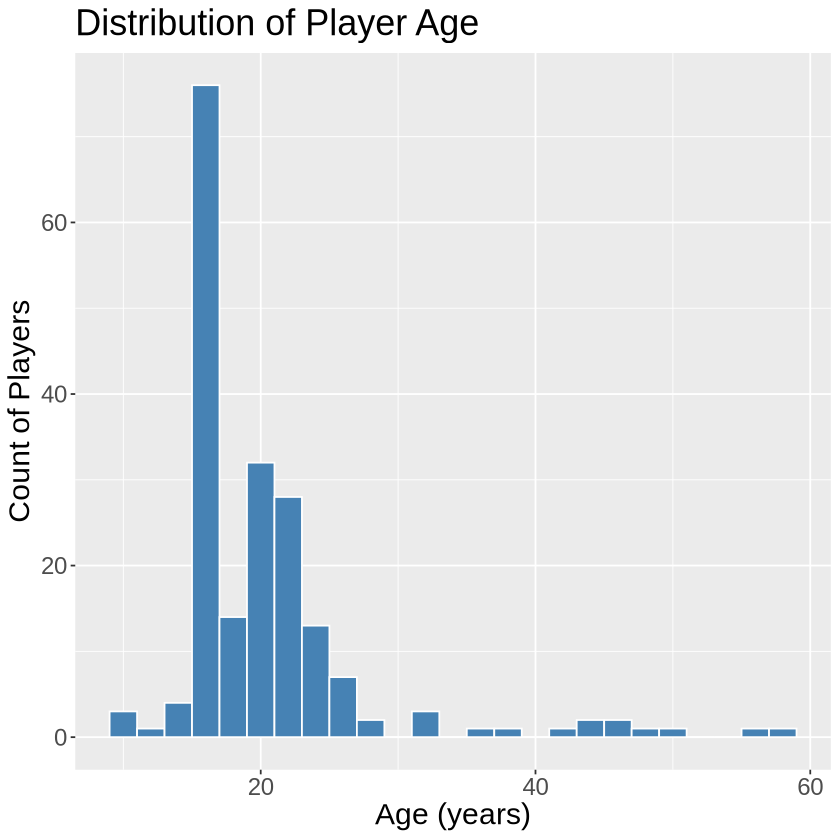

In [13]:
theme_update(text = element_text(size = 18))
ggplot(players_tidy, aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "steelblue", color = "white") +
  labs(
    title = "Distribution of Player Age",
    x = "Age (years)",
    y = "Count of Players"
  )


Figure 1: 
The histogram above clearly illustrates that the majority of players are around 10 to 28 years old, with the highest 
number of players at age 16 with the highest peak on the graph. Additionally, as player age increases the number of 
players decrease as illustrated by the least amount of players in the 60 age range. This graph helps us possibly determine that players in the age range of 10 to 28 may be more likely to subscribe to a game-related newsletter, since they spend the most time playing on the Minecraft server, whereas the older ages from about 30-60 don't play as much Minecraft, indicating they are less likely to subscribe to a game-related newsletter. 

#### 1.3.3 Played Hours Distribution

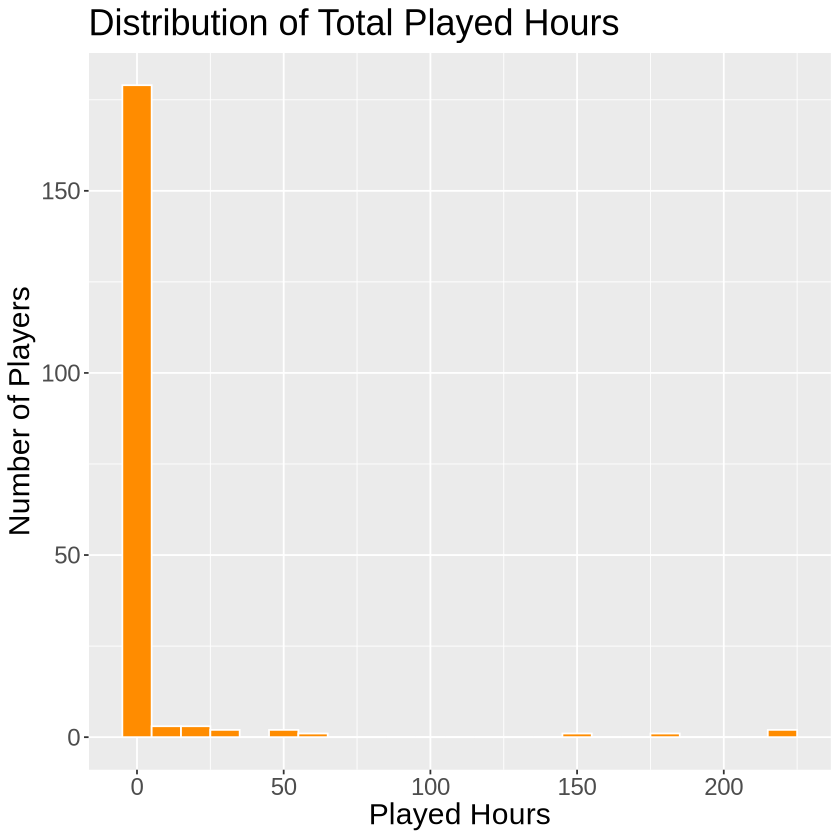

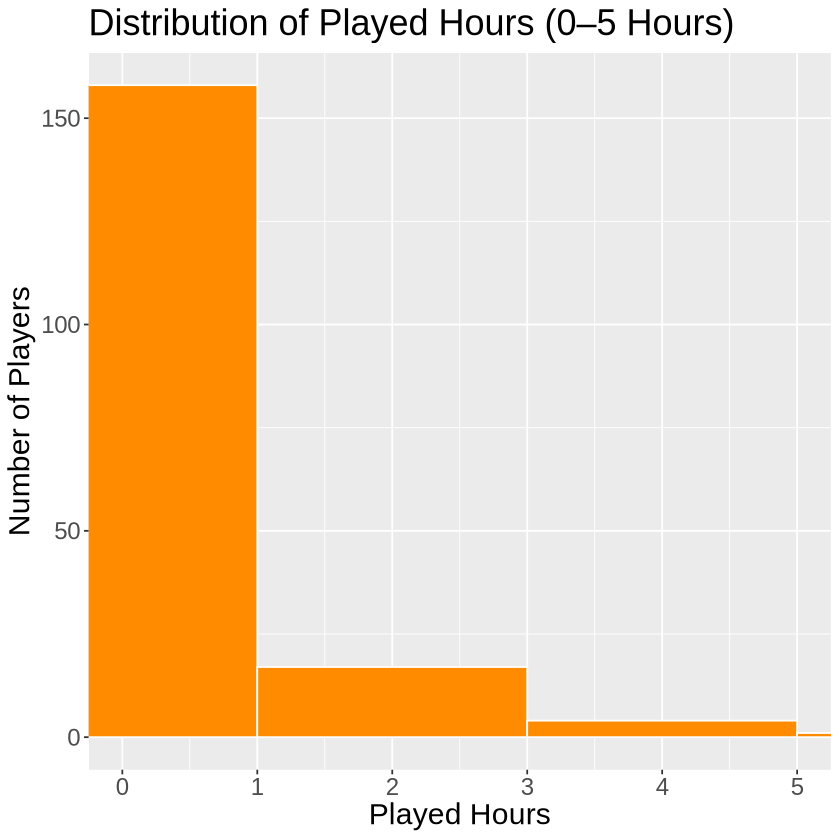

In [14]:
ggplot(players_tidy, aes(x = played_hours)) +
  geom_histogram(binwidth = 10, fill = "darkorange", color = "white") +
  labs(
    title = "Distribution of Total Played Hours",
    x = "Played Hours",
    y = "Number of Players"
  )

ggplot(players_tidy, aes(x = played_hours)) +
  geom_histogram(binwidth = 2, fill = "darkorange", color = "white") +
  coord_cartesian(xlim = c(0, 5)) +
  labs(
    title = "Distribution of Played Hours (0–5 Hours)",
    x = "Played Hours",
    y = "Number of Players"
  )


Figure 2: 
Both histograms above demonstrate that the majority of players only logged onto the Minecraft server for about 1-3hrs. The highest amount of players logged on for approximately 1 hour, as illustrated by the highest peak on the graphs. There are some extreme outliers where players were logged on for 150-215hrs. These values may have been due to players logging on and possibly leaving their servers open when they were not playing/not properly logging off. This data can help us determine that since the majority of players only log on for such a short period of time, they may not be engaged enough to subsrcibe to a game-related newsletter, however some of the players who log on for 3-5 hours may be more inclined to subscribe, since they appear to be more engaged/spend more time on the server. So, it appears as though only a small majority of players may subscribe to the newsletter. 

#### 1.3.4 Played Hours vs Age

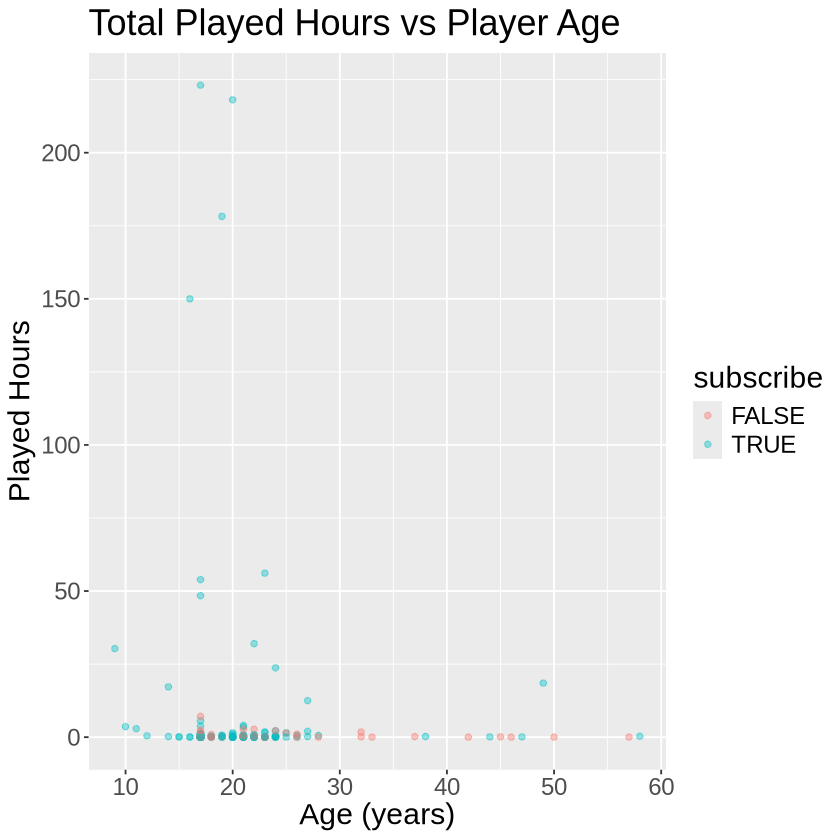

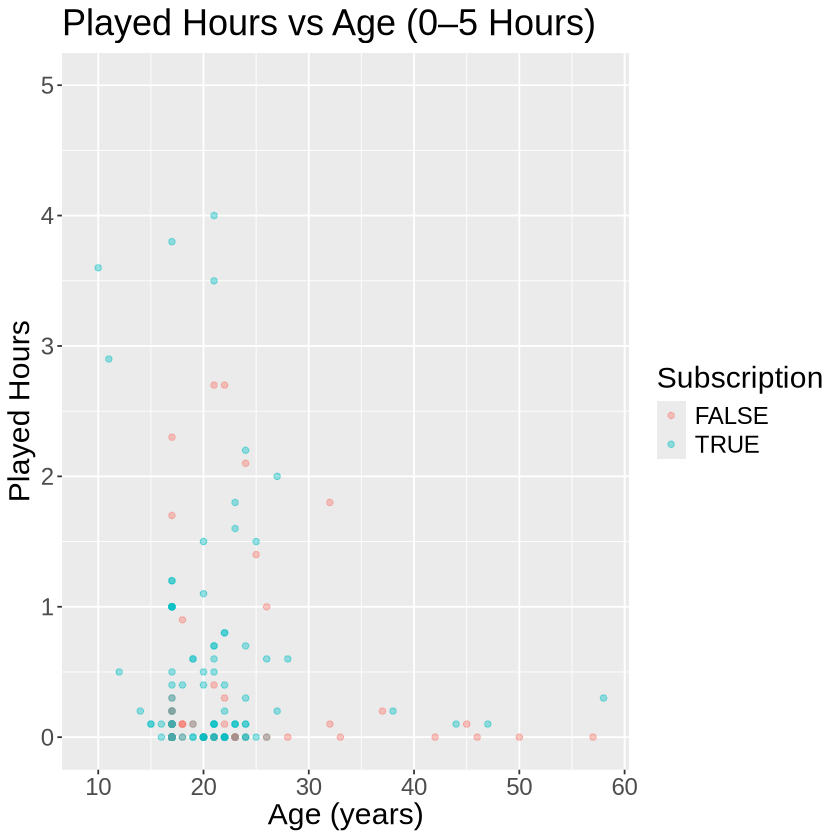

In [15]:
ggplot(players_tidy, aes(x = Age, y = played_hours, colour = subscribe)) +
  geom_point(alpha = 0.4) +
  labs(
    title = "Total Played Hours vs Player Age",
    x = "Age (years)",
    y = "Played Hours"
  )

ggplot(players_tidy, aes(x = Age, y = played_hours, colour = subscribe)) +
  geom_point(alpha = 0.4) +
  coord_cartesian(ylim = c(0, 5)) +
  labs(
    title = "Played Hours vs Age (0–5 Hours)",
    x = "Age (years)",
    y = "Played Hours",
    colour = "Subscription"
  )



Figure 3: 
Both scatter plots above shows that players aged 10-29 seem to be accumulating more hours played, with values ranging from 50 to over 200 total hours played, whereas older ages such as 30-60 rarely play, since most of their playtime is less than one hour. This graph helps shows us that since the majority of players aged 10-29 play for the longest amount of time, they seem to be more engaged on the Minecraft server so they are likely more inclined to subscribe to a game-related Newsletter, rather than players aged 30-60, (this graph helps support/shows the same general trend as in Fig 1). 

#### 1.3.5 Experience Level by Mean Played Hours

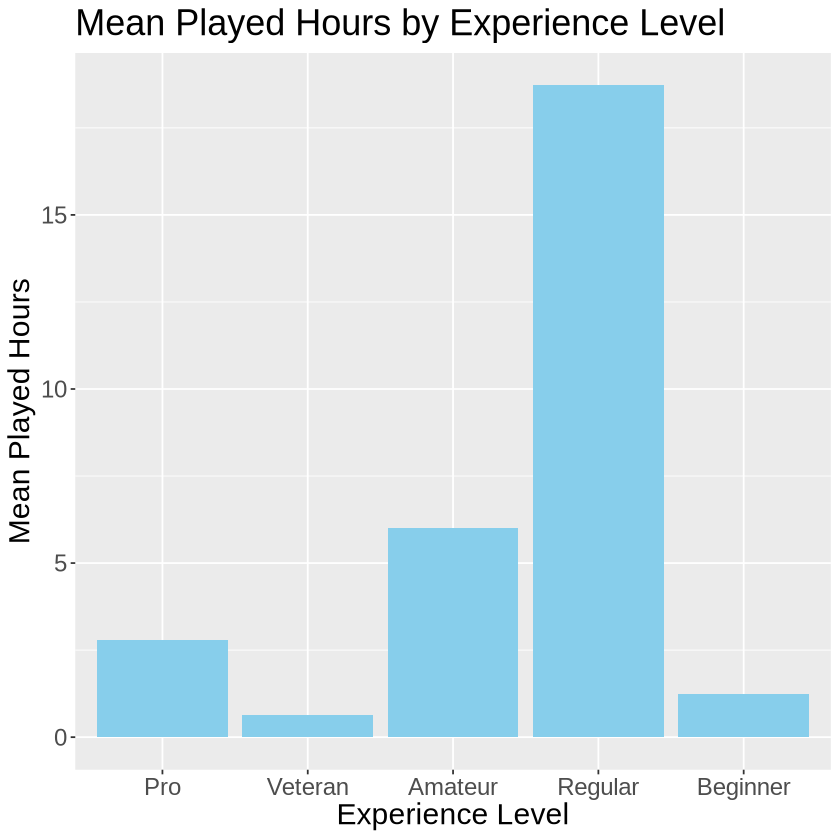

In [16]:
players_tidy |>
  group_by(experience) |>
  summarise(mean_played = mean(played_hours, na.rm = TRUE)) |>
  ggplot(aes(x = experience, y = mean_played)) +
  geom_col(fill = "skyblue") +
  labs(
    title = "Mean Played Hours by Experience Level",
    x = "Experience Level",
    y = "Mean Played Hours"
  )


Figure 4:
This bar graph shows that the highest amount of played hours come from Regulars, so they are the most likely to subsrcibe to a game related newsletter, due to their frequent Minecraft server engagement. On the contrary Beginners, and Veternas are the least likely to subscribe since they play the least, then Amatuers and Pro's are the second most likely to subscribe, since they play more than Veternas and Beginners, but less than Regulars. 

# 2. Methods and Results - K-Nearest Neighbors (K-NN) Classification

### Why this method is appropriate
* K-NN directly supports a categorical response variable with known classes, in this case is **subscribe** (YES/NO).
* It works with both numeric and categorical predictors once scaling/encoding is applied.
* K-NN is part of the course teachings

### Assumptions required
* Distances between players must meaningfully reflect similarity after standardizing numeric predictors.
* Players who are “nearby” in feature space are assumed to have similar subscription behavior.

### Potential limitations or weaknesses
* Sensitive to variable scaling; numeric predictors must be standardized or they dominate the distance metric.
* Performance can decrease in effectiveness with too many predictors.
* Distance-based handling of categorical variables may not fully capture their meaning.

### How the model will be compared and selected.


### Data processing plan
After data was made tidy in section 1.3, this section will focus on the following:
* Perform a 75% training / 25% testing split, grouped by **subscribe**.
* Use 5-fold cross-validation on the training data.
* Tune the number of neighbors K across a range of values.
* Select the K that gives the highest average cross-validated accuracy.

* Standardize numeric predictors (**age**, **played_hours**) using `step_scale()` and `step_center()`.
* Use only the training set for resampling, cross-validation, and model tuning.
* Evaluate the final model once on the test set to estimate out-of-sample prediction accuracy.


### 2.1 Tuning the classifier

In [17]:
slice(players_tidy, 1:8) #for preview

subscribe,experience,played_hours,Age,gender
<fct>,<fct>,<dbl>,<dbl>,<fct>
TRUE,Pro,30.3,9,Male
TRUE,Veteran,3.8,17,Male
FALSE,Veteran,0.0,17,Male
TRUE,Amateur,0.7,21,Female
TRUE,Regular,0.1,21,Male
TRUE,Amateur,0.0,17,Female
TRUE,Regular,0.0,19,Female
FALSE,Amateur,0.0,21,Male


### 2.1.1 Train/Test Split of Players Dataset

In [18]:
set.seed(1234) # Make this data split reproducible
players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe) # 75% training / 25% testing split
players_train <- training(players_split)
players_test <- testing(players_split)

### 2.1.2 Creating a Recipe to Standardize Data With Training Split

In [19]:
players_recipe <- recipe(subscribe ~ ., data = (players_train)) |>
    step_dummy(experience, gender) |> #step_dummy was used to convert these factor variables into encodings to be predictors
    step_zv(all_predictors()) |>       #remove zero-variance columns
    step_scale(all_predictors()) |>
    step_center(all_predictors())

### 2.1.3 Creating the Classfier Using K-nearest Neighbours

In [54]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> #Optimal numbers of K-nearest neighbours initially using the tune() function.
            set_engine("kknn") |> #knn engine is used for K-nearest Neighbours classification for straight-line distance.
            set_mode("classification") #classification mode is desired.

k_vals <- tibble(neighbors = seq(from = 1, to = 51, by = 1))

### 2.1.4 Five-fold Cross Validation and Obtain Accuracies

In [55]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe) #Splitting training data into 5 folds for cross validation

In [56]:
players_fit_results <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(knn_tune) |>
             tune_grid(
                 resamples = players_vfold,
                 grid      = k_vals) |>
             collect_metrics()

players_accuracies <- players_fit_results |>
  filter(.metric == "accuracy")

players_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6000657,5,0.020046201,Preprocessor1_Model01
2,accuracy,binary,0.6069622,5,0.012798890,Preprocessor1_Model02
3,accuracy,binary,0.6628736,5,0.027493619,Preprocessor1_Model03
4,accuracy,binary,0.6421839,5,0.037182442,Preprocessor1_Model04
5,accuracy,binary,0.6900000,5,0.027962945,Preprocessor1_Model05
6,accuracy,binary,0.6833333,5,0.028160920,Preprocessor1_Model06
7,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model07
8,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model08
9,accuracy,binary,0.7244828,5,0.013470362,Preprocessor1_Model09


### 2.1.5 Accuracy Across Neighborhood Sizes (K = 1 to 51)

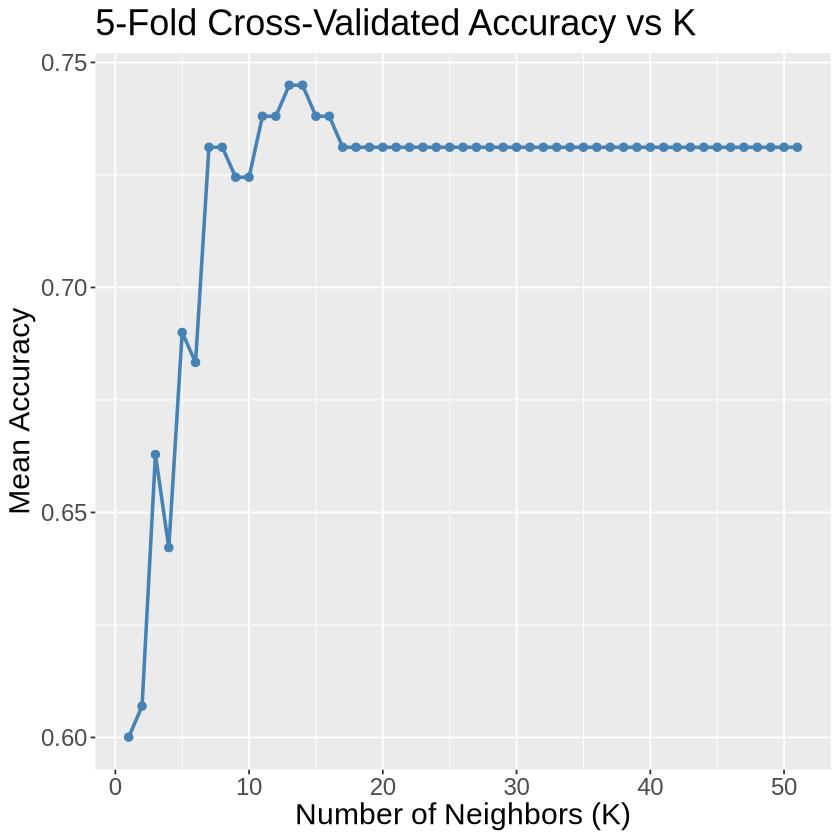

In [57]:
five_fold_accuracy_vs_k = players_accuracies |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line(color = "steelblue", linewidth = 1) +
  geom_point(color = "steelblue", size = 2) +
  labs(
    title = "5-Fold Cross-Validated Accuracy vs K",
    x = "Number of Neighbors (K)",
    y = "Mean Accuracy"
  )

five_fold_accuracy_vs_k

The graph above shows sharp increases in accuracy from k=1 to k=8, and then reaches it's peak around k=13 before leveling off. This means that the model's acuracy becomes better as k increases, but it's highest accuracy around k=13. After that, adding more nieghbors causes the accuracy to level off.

### 2.1.6 Selecting the Optimal K Value (Highest Accuracy, Smallest K)

In [24]:
best_k <- players_accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 13

### 2.2 Test Set Classification Results for the Tuned K-NN Model (K = 13)

### 2.2.1 K-NN Model Creation

In [58]:
knn_final <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors   = best_k
) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_final) |>
  fit(data = players_train)


### 2.2.2 Generate predictions on test dataset

In [59]:
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

head(players_test_predictions)

.pred_class,subscribe,experience,played_hours,Age,gender
<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
TRUE,TRUE,Pro,30.3,9,Male
TRUE,FALSE,Veteran,0.0,17,Male
TRUE,TRUE,Regular,0.1,21,Male
TRUE,TRUE,Amateur,0.0,17,Female
TRUE,TRUE,Amateur,0.2,22,Male
TRUE,TRUE,Veteran,0.0,17,Non-binary


### 2.2.3 Final Evaluation (Test Set Accuracy)

In [60]:
players_test_metrics <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

players_test_accuracy <- players_test_metrics |>
  filter(.metric == "accuracy") |>
  pull(.estimate)

players_test_accuracy

[1] 0.7142857

### 2.2.4  Visualization of Accuracy

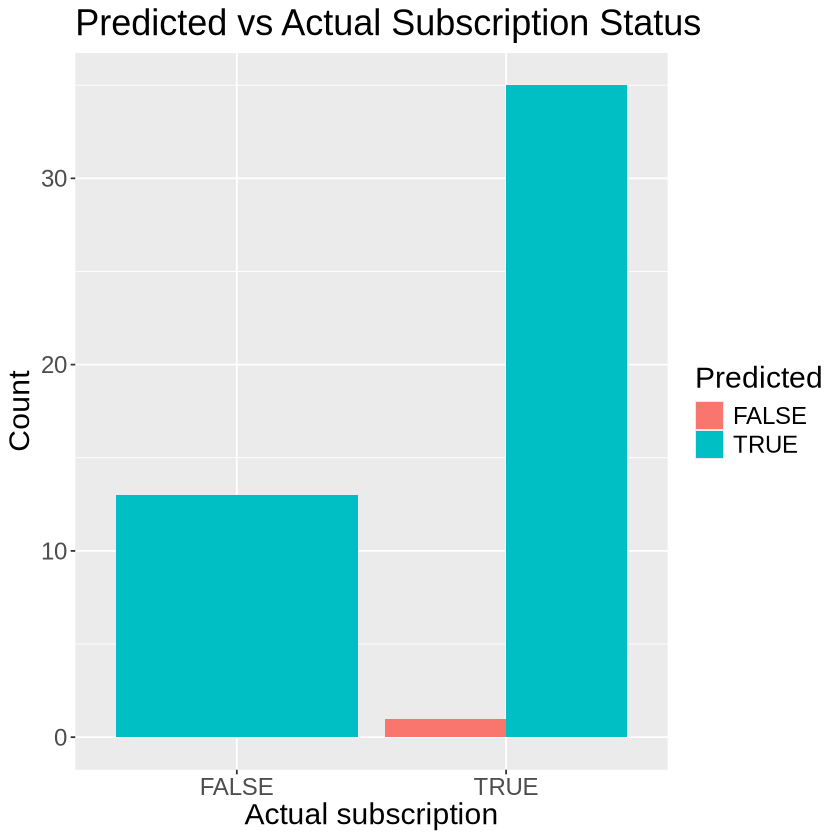

In [61]:
players_test_predictions |>
  count(subscribe, .pred_class) |>
  ggplot(aes(x = subscribe, y = n, fill = .pred_class)) +
  geom_col(position = "dodge") +
  labs(
    title = "Predicted vs Actual Subscription Status",
    x = "Actual subscription",
    y = "Count",
    fill = "Predicted"
  )


### 2.2.5  Confusion Matrix

In [44]:
players_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)


          Truth
Prediction FALSE TRUE
     FALSE     2    3
     TRUE     11   33

### 2.3 Test Set Classification Results for a Non-Optimal K-NN Classifier (K = 5)

Although cross-validation optimized accuracy at K=13, the model failed to identify FALSE subscription cases (0 true negatives). To understand both subscribers and non-subscribers, this behavior is unacceptable. We therefore select a smallest K without decreasing accutacy too much (refer to Graph 2.1.5). K=5 was chosen, and it provides more balanced performance. This is a sign of underfitting, therefore we choose a smaller K without compensating accuracy.

.pred_class,subscribe,experience,played_hours,Age,gender
<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
TRUE,TRUE,Pro,30.3,9,Male
TRUE,FALSE,Veteran,0.0,17,Male
TRUE,TRUE,Regular,0.1,21,Male
TRUE,TRUE,Amateur,0.0,17,Female
TRUE,TRUE,Amateur,0.2,22,Male
TRUE,TRUE,Veteran,0.0,17,Non-binary


[1] 0.7346939

          Truth
Prediction FALSE TRUE
     FALSE     4    4
     TRUE      9   32

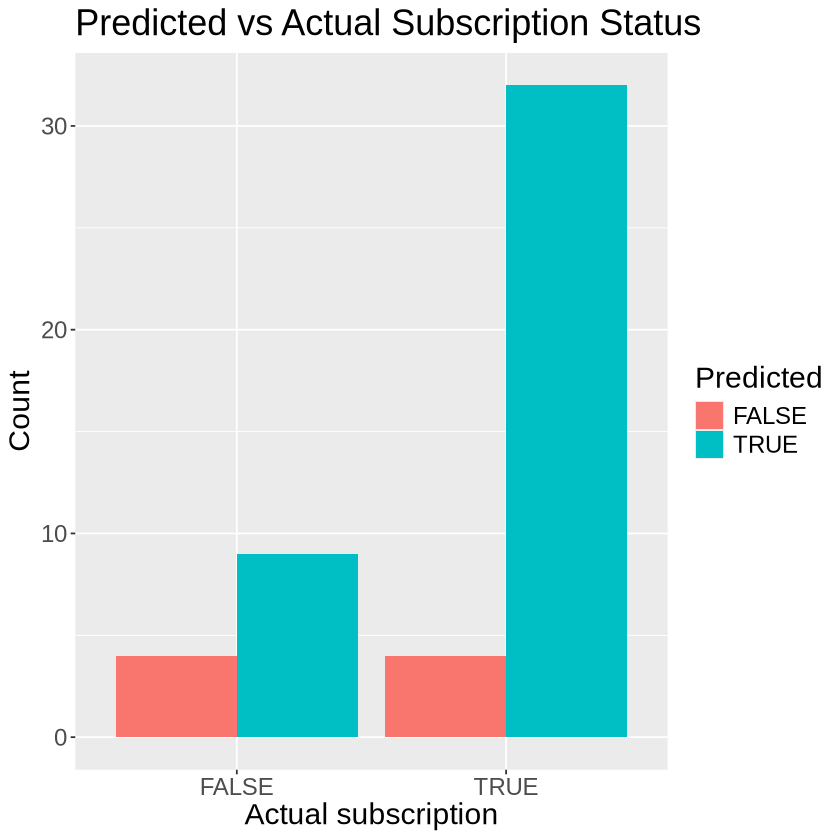

In [53]:
# Model Specification K=5
knn_final <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors   = 5
) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_final) |>
  fit(data = players_train)

# Generate Predictions
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

head(players_test_predictions)

# Gather Metrics
players_test_metrics <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

players_test_accuracy <- players_test_metrics |>
  filter(.metric == "accuracy") |>
  pull(.estimate)

players_test_accuracy

# Results
players_test_predictions |>
  count(subscribe, .pred_class) |>
  ggplot(aes(x = subscribe, y = n, fill = .pred_class)) +
  geom_col(position = "dodge") +
  labs(
    title = "Predicted vs Actual Subscription Status",
    x = "Actual subscription",
    y = "Count",
    fill = "Predicted"
  )


players_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)


# 3. Discussion

### Explanation for why K=5 was chosen over Optimal K=13 determined by 5-Fold CV
Although cross-validation identified K = 13 as the value with the highest accuracy, we observed a strong underfitting effect, where the model predicted almost all players as subscribers, failing to identify non-subscribers. This behavior aligns with the discussion in Section 6.6.3 of the textbook, where large values of K cause excessive smoothing and lead to underfitting. Because the accuracy curve was relatively flat across K (0.69 at K = 5 vs 0.738 at K = 13), choosing a smaller K provided a better balance between overfitting and underfitting. In particular, K = 5 produced a substantially more balanced confusion matrix and achieved a better accuracy.